In the following notebook I create the spatial profile of signal transients. Signals were previously extracted, smoothened by the optimal Gauss-kernel and also significant events were detected on each signal - A soma, A dendrite, B soma. Spatial profile in this term means that  whenever a signal reaches a specific treshold (theta_upper) and does not go under another (theta_lower) thershold - I use the same signal event detection algorithm and its parameters for transient profiling - we can observ an event where the signal has a local peak. This event is also observable if look the total view of 3D frames, or if we create separate windows for each somas and dendrite. Whatever is the case, when a transient occurs in the dendrites for instance, we should see the spatial characteristics of that specific transient event. This means, in cases when the dendrite has true event its spatial contrast in space is clearly visible, whereas in case of false transients (i.e.: noise) there is no visible or weakly visible contrast between the dendritic mask and the other fields of the window (or the total frame).

Transient profiles were calculated by using the weighted sum of ith video frames, where I weight them by the ith element of the transient time course then summing it. Then I normalized by the total magnitude of the transient event (Gauthier et al., 2022). To decide which transient is true, first I implemented a function that decides it automatically based on the orginal synthetic spikes.

Reference:

Gauthier, J. L., Charles, A. S., Pillow, J. W., Tank, D. W., Nieh, E. H., & Koay, S. A. (2022) Detecting and correcting false transients in calcium imaging. Nature methods. Retrieved January 30, 2023, from https://pubmed.ncbi.nlm.nih.gov/35347320


In [54]:
# packages
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import scipy 

from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
from skimage.draw import polygon2mask
from shapely import Polygon
from shapely import affinity
from shapely.geometry.polygon import Polygon

I load every data that was created in the synthetic data generation process. I will use the commented lines for the spatial profiles

In [55]:
# First, I will use the whole tensor to create the source profiles - 3D windows in whihch I observe transient events.
synthetic_dF = np.load('synthetic_dF.npy')

# I will use the smoothened signals.
synthetic_a_soma_signal_smooth = np.load('synthetic_a_soma_signal_smooth.npy', allow_pickle = True) 
synthetic_a_dendrite_signal_smooth = np.load('synthetic_a_dendrite_signal_smooth.npy', allow_pickle = True)
synthetic_b_soma_signal_smooth = np.load('synthetic_b_soma_signal_smooth.npy', allow_pickle = True)

# I will use the original signals as well.
synthetic_dF_a_soma = np.load('synthetic_dF_a_soma.npy', allow_pickle = True)
synthetic_dF_a_dend = np.load('synthetic_dF_a_dend.npy', allow_pickle = True)
synthetic_dF_b_soma = np.load('synthetic_dF_b_soma.npy', allow_pickle = True)

# Masks
masks_main = np.load('masks.npy', allow_pickle = True)
asomabase = np.load('asomabase.npy', allow_pickle = True)
adendritebase = np.load('adendritebase.npy', allow_pickle = True)
bsomabase = np.load('bsomabase.npy', allow_pickle = True)

# Detected events (spikes)
synthetic_somatic_event1 = np.load('synthetic_somatic_event1.npy', allow_pickle = True)
synthetic_dendritic_event = np.load('synthetic_dendritic_event.npy', allow_pickle = True)
synthetic_somatic_event2 = np.load('synthetic_somatic_event2.npy', allow_pickle = True)

# OG spikes
synthetic_spikes_a_soma = np.load('synthetic_spikes_a_soma.npy', allow_pickle = True)
synthetic_spikes_a_dendrite = np.load('synthetic_spikes_a_dendrite.npy', allow_pickle = True)
synthetic_spikes_b_soma = np.load('synthetic_spikes_b_soma.npy', allow_pickle = True)

In the next cell, I have added a 5 long zero-pad to the smoothened signals.
This is needed in cases when there is a transient occuring at the very end of the signal.

In [56]:
pad_signal = np.zeros(100)
synthetic_a_soma_signal_smooth = np.append(synthetic_a_soma_signal_smooth, pad_signal)
synthetic_a_dendrite_signal_smooth = np.append(synthetic_a_dendrite_signal_smooth, pad_signal)
synthetic_b_soma_signal_smooth = np.append(synthetic_b_soma_signal_smooth, pad_signal)
len_signals = len(synthetic_b_soma_signal_smooth)

In the next cell I create I pad the movie tensor in case of plotting signals conveniently when it occurs at the very end of the signal array.

In [57]:
pad_len = 100
zero_pad_array = 100*100*pad_len
pad_dF = np.zeros(zero_pad_array)
pad_dF = pad_dF.reshape(100,100,pad_len)
synthetic_dF = np.append(synthetic_dF, pad_dF, axis=2)

Copy the tensor and create the mean image of it:

In [58]:
synthetic_movie = synthetic_dF.copy()


In the next cell I create a function which expands the ROI masks:

In [59]:
def roi_expander(roi, d = 2):
    
    d2 = d*2
    
    roi = np.ma.where(roi)
    roi = list(np.column_stack(roi))
    np.unique(np.array(roi), axis=0)
    
    for i in np.arange(len(roi)):
        x = roi[i][0]
        y = roi[i][1]
        roi.append([x-d,y+d])
        roi.append([x+d,y-d])
        roi.append([x+d,y+d])
        roi.append([x-d,y-d])
          
    new_roi = np.unique(np.array(roi), axis=0)
    
    return new_roi

In [60]:
# def source_corner_coordinates(new_roi):
#     minimum0 = min(new_roi[:,0])
#     maximum0 = max(new_roi[:,0])
#     minimum1 = min(new_roi[:,1])
#     maximum1 = max(new_roi[:,1])
#     return minimum0, maximum0, minimum1, maximum1

Create the new masks:

In [61]:
asoma_expanded = roi_expander(asomabase, 6)
adendrite_expanded = roi_expander(adendritebase, 6)
bsoma_expanded = roi_expander(bsomabase, 6)

The following funcion (transient_event_detecor) is the previoulsy introduced function - made for transient event detection.

In [62]:
def event_detector(signal, theta_upper = 1.65, theta_lower = 1.6): 
    
    N = len(signal)
    
    event = np.zeros(N)
    transient = np.zeros(N)
    start_end = []
    
    refr = 0
    start_end_i = np.zeros(2)
    
    for i in np.arange(1,N):
        if ((signal[i] > theta_upper) and (signal[i-1] < theta_upper) and (refr == 0)):
            event[i] = 1 
            refr = 1
            start_end_i[0] = i
        if ((signal[i]<theta_lower) and (signal[i-1]>theta_lower) and (refr == 1)):
            refr = 0
            start_end_i[1] = i
            start_end.append(start_end_i)
            start_end_i = np.zeros(2)
        if (refr == 1):
            transient[i] = 1
    if ((start_end_i[0] > 0) & (start_end_i[1] == 0)):
        start_end_i[1] = N
        start_end.append(start_end_i)
    
    return event, transient, start_end

## Here we specifiy the threshold of the etected transient event:

Here I specifiy the smoothed signal that we would like to call for transient event detection and use later for transient profile creation.

In [63]:
signal_a_soma = synthetic_a_soma_signal_smooth.copy()
signal_a_dend = synthetic_a_dendrite_signal_smooth.copy()
signal_b_soma = synthetic_b_soma_signal_smooth.copy()

actual_signal = signal_a_dend

threshold_upper = 0.25
threshold_lower = 0.1

event, transient, start_end = event_detector(actual_signal, threshold_upper, threshold_lower)

Event length:

In [64]:
event_length = np.array(start_end)[:,1] - np.array(start_end)[:,0]

Lists of the begining and the end of transient events:

In [65]:
lista_lower = np.array(start_end)[:,0].astype(int)
lista_upper = np.array(start_end)[:,1].astype(int)

In [66]:
#Uncomment the actual compartment!

# a_soma_list_lower = lista_lower
# a_soma_list_lower_save = np.save('a_soma_list_lower', a_soma_list_lower)

dend_list_lower = lista_lower
dend_list_lower_save = np.save('dend_list_lower', dend_list_lower)

# b_soma_list_lower = lista_lower
# b_soma_list_lower_save = np.save('b_soma_list_lower', b_soma_list_lower)

The transient_profile function creates the transient profiles based on the smoothened signal, the base picture, the minimum, the maximum value of the tranisient event and the step size units between the min and the max (default = 1). It is calculating the transient profiles were calculated by using the weighted sum of ith video frames, where I weight them by the ith element of the transient time course then summing it (Gauthier et al., 2022). 

Within the function, first, I modify the end coordinate of the transient event in manner, that in case when it occurs in the end a transient profile still can be created (starts to create the profile from the element of index -6). Second, I add 5 extra elements to the transient event in both - and + diretion to show the signal not only when it hits the thresholds (theta_upper, theta_lower). Thirdly I cut out signal and the frames in the defined time sequence (index) from the signal and the source profile window. Afther this, I multiply the slice of the signal and the source profile sequence that I got in the last step. Finally, I sum the result through the event (axis = 2 - time angle) and extract the mean of the pixel-correlational coeffiecients that has been calculated between the mask and the transient profile.

In [67]:
def transient_profile(transient_signal, movie_data, start, stop):
    
    stop = stop
    
    if stop >= len(transient_signal)-1:
        stop = len(transient_signal)-6
    
    index = np.arange(start-5, stop+5)
    transient = transient_signal[index]
    transient_movie_data = movie_data[:,:,index]
    W = transient * transient_movie_data #weighted_frames
    transient_pic = np.sum(W, axis=2)
    normalized_trans_pic = transient_pic/sum(transient**2)
    trans = normalized_trans_pic
    return trans

Saving the starting index paramteres of transients belonging to a certain soma or dendrite.

Essentially, the magazine function plots nine (3x3) items to one pdf page. It shows the total spatial (constant) viev of the spatial data, the base profile, the transient profile, the signals of every compartment (somas and dendrite) and their original signal - before the extraction from masks. Since, one page consits one transient event, the function creates a pdf file that has the same number of pages with the detected transient events. It is important to note that the function only creates the transient profiles of one neural compartment (i.e.: dendrites), so we have to run the function 3 times. To merge these pdf files I have created a different code in a different notebook.

Notice: All the transient event lengths are marked by moccasin color on the extracted signal plots and all the true transients has red frame on the transient profile image.

In [68]:
def magazine(prof_mask, smooth_signal, source_profile, base_profile,
             index_start, index_stop, synthetic_dF_actual, want, offset = 50,
             title = '{0}. dendritic transient', name = ''): 
    
    l = len(index_start)
    for i in range(l):
        
        fig = plt.figure(i)
        fig.set_figheight(50)
        fig.set_figwidth(42)
        
        plt.rcParams.update({'figure.max_open_warning': 0})
        
        plt.subplots_adjust(hspace=0.5)
    
        
        rows = 3
        columns = 3
        
        trans = transient_profile(smooth_signal, source_profile, index_start[i], index_stop[i])
        
        buffered_mask = np.array(prof_mask)
        mask = polygon2mask(trans.shape, buffered_mask)
        result = ma.masked_array(trans, np.invert(mask))
        
        base_result = ma.masked_array(base_profile, np.invert(mask))
        

        x_var = trans[tuple(prof_mask.T)].tolist()
        y_var = base_profile[tuple(prof_mask.T)].tolist()
        cor = np.round(np.corrcoef(x_var, y_var)[0][1], 3)

        interval_min = offset
        
        if smooth_signal[index_start[i]+2] > 2:
            interval_min = offset +20
        else:
            interval_min = offset
        
        interval_max = interval_min + (index_stop[i]-index_start[i]) + 1
        
        
        #time scale parameters
        len_signal = len(synthetic_a_soma_signal_smooth)
        time_len_s = round(903/len_signal,2) #!
        start_point = index_start[i]-offset
        end_point = index_stop[i]+offset
        time_interval = round((end_point-start_point)/5)
        lbls = [i*time_len_s for i in list(range(start_point, end_point, time_interval))]
        lbls = [round(num, 1) for num in lbls]
        tcks = list(range(0,end_point-start_point, time_interval))
        
        # minimum0, maximum0, minimum1, maximum1 = source_corner_coordinates(prof_mask)
        
        # Adaptive Y-lim:
        # idk = smooth_signal[index_start[i]-5:index_stop[j]+5]
        # min_idk = min(idk)
        # max_idk = max(idk)
        # minmax_idk = (abs(min_idk)+abs(max_idk))/2
        # poaksd = minmax_idk/4
        # plt.ylim([min_idk-poaksd, max_idk+poaksd])
        
        #1
        fig.add_subplot(rows, columns, 1,)
        plt.imshow(masks_main)
        plt.title('A - Total view \n', fontsize = 40)
        plt.axis('off')

        #2
        fig.add_subplot(rows, columns, 2)
        plt.imshow(base_result)
        plt.title('B - Source profile \n', fontsize =40)
        plt.axis('off')
        
        #3
        ax = fig.add_subplot(rows, columns, 3)
        ax.imshow(result)
        plt.title('C - Transient profile \n r = {0}'.format(cor), fontsize = 40)
        # plt.xlim(minimum1, maximum1)
        # plt.ylim(maximum0, minimum0)
        plt.xticks(color = 'w')
        plt.yticks(color = 'w')
        
        want = want
        want_i = [index_start[k] for k in want]
        
        color = "red" if index_start[i] in want_i else "white"
        for x in ["top","left","right","bottom"]:
            ax.spines[x].set_color(color)
            ax.spines[x].set_linewidth(16)
        
        
        #4
        fig.add_subplot(rows, columns, 4)
        plt.plot(synthetic_a_soma_signal_smooth[index_start[i]-offset:index_stop[i]+offset], 'k')
        plt.title('D - A Soma dF/F \n', fontsize = 40)
        plt.ylim([-0.5, 2.5])
        plt.xlabel('Time (s)', fontsize = 30, labelpad = 5)
        plt.ylabel('Amplitude', fontsize = 30, labelpad = -15)
        plt.xticks(ticks = tcks, labels = lbls, fontsize = 30)
        plt.yticks(fontsize = 30)
        plt.axvspan(interval_min, interval_max, color='moccasin', alpha=0.7)

        #5
        fig.add_subplot(rows, columns, 5)
        plt.plot(synthetic_a_dendrite_signal_smooth[index_start[i]-offset:index_stop[i]+offset], 'r')
        plt.title('E - A Dendrite dF/F \n', fontsize = 40)
        plt.ylim([-0.5, 2.5])
        plt.xlabel('Time (s)', fontsize = 30, labelpad = 5)
        plt.ylabel('Amplitude', fontsize = 30, labelpad = -15)
        plt.xticks(ticks = tcks,labels = lbls, fontsize = 30)
        plt.yticks(fontsize = 30)
        plt.axvspan(interval_min, interval_max, color='moccasin', alpha=0.5)
        
        #6
        fig.add_subplot(rows, columns, 6)
        plt.plot(synthetic_b_soma_signal_smooth[index_start[i]-offset:index_stop[i]+offset], 'b')
        plt.title('F - B Soma dF/F \n', fontsize = 40)
        plt.ylim([-0.5, 2.5])
        plt.xlabel('Time (s)', fontsize = 30, labelpad = 5)
        plt.ylabel('Amplitude', fontsize = 30, labelpad = -15)
        plt.xticks(ticks = tcks,labels = lbls, fontsize = 30)
        plt.yticks(fontsize = 30)
        plt.axvspan(interval_min, interval_max, color='moccasin', alpha=0.5)
        
        #7
        fig.add_subplot(rows, columns, 7)
        plt.plot(synthetic_dF_a_soma[index_start[i]-offset:index_stop[i]+offset], 'k')
        plt.ylim([-50, 800])
        plt.xlabel('Time (s)', fontsize = 30, labelpad = 5)
        plt.ylabel('Amplitude', fontsize = 30, labelpad = 5)
        plt.xticks(ticks = tcks,labels = lbls, fontsize = 30)
        plt.yticks(fontsize = 30)
        plt.title('G - A Soma original signal \n', fontsize = 40)
        
        #8
        fig.add_subplot(rows, columns, 8)
        plt.plot(synthetic_dF_a_dend[index_start[i]-offset:index_stop[i]+offset], 'r')
        plt.ylim([-50, 800])
        plt.xlabel('Time (s)', fontsize = 30, labelpad = 5)
        plt.ylabel('Amplitude', fontsize = 30, labelpad = 5)
        plt.xticks(ticks = tcks,labels = lbls, fontsize = 30)
        plt.yticks(fontsize = 30)
        plt.title('H - A Dendrite original signal \n', fontsize = 40)
            
        #9
        fig.add_subplot(rows, columns, 9)
        plt.plot(synthetic_dF_b_soma[index_start[i]-offset:index_stop[i]+offset], 'b')
        plt.ylim([-50, 800])
        plt.xlabel('Time (s)', fontsize = 30, labelpad = 5)
        plt.ylabel('Amplitude', fontsize = 30, labelpad = 5)
        plt.xticks(ticks = tcks, labels = lbls, fontsize = 30)
        plt.yticks(fontsize = 30)
        plt.title('I - B Soma original signal \n', fontsize = 40)
        
        title_num = 1
        title_num = title_num + i
          
        fig.suptitle(title.format(title_num), fontsize = 40, weight = 'bold')
        
        pdf_pages = len(lista_upper)
        
        with PdfPages(name) as pdf:
            for fig in range(pdf_pages):
                plt.figure(fig)
                pdf.savefig(bbox_inches="tight")

Correlation function:

In [69]:
def corr_coeffs(expanded_ROI_coordinates, smoothed_signal, synthetic_movie_data, static_ROImask, 
               trans_event_start, trans_event_end):
    
    cor_list = []
    cor_list_i = np.zeros(2)

    n = len(trans_event_start)
    for i in range(n):
        
        transient_pic = transient_profile(smoothed_signal, synthetic_movie_data, trans_event_start[i], trans_event_end[i])
        
        x_var = transient_pic[tuple(expanded_ROI_coordinates.T)].tolist()
        y_var = static_ROImask[tuple(expanded_ROI_coordinates.T)].tolist()
        cor_coeff = np.round(np.corrcoef(x_var, y_var)[0][1], 3)
        cor_list_i[0] = lista_lower[i]
        cor_list_i[1] = cor_coeff
        cor_list.append(cor_list_i)
        cor_list_i = np.zeros(2)
                
    return cor_list

## From here we specifiy the correlation list according to the actual compartment and the plots of the transient profiles of the actual compartment:

In [70]:
#Uncomment the actual correlation array!

# cor_asom = corr_coeffs(asoma_expanded, synthetic_a_soma_signal_smooth, synthetic_movie, asomabase, lista_lower, lista_upper)
cor_dend = corr_coeffs(adendrite_expanded, synthetic_a_dendrite_signal_smooth, synthetic_movie, adendritebase, lista_lower, lista_upper)
# cor_bsom = corr_coeffs(bsoma_expanded, synthetic_b_soma_signal_smooth, synthetic_movie, bsomabase, lista_lower, lista_upper)

In [71]:
#need to specifiy the actual compartment

actual_cor = cor_dend

correlation_indices = np.array(actual_cor)[:,0].astype(int)
correlation_coefficients = np.array(actual_cor)[:,1]

Function for sperating true and false events (for spatial profile) and true and false correlations (for correlation histogram):

In [72]:
def matched_index(l1, l2):
    l2 = set(l2)
    return [i for i, el in enumerate(l1) if el in l2]

In [79]:
def truefalse(cor_coeffs, cor_list, og_spikes, detected_spikes, trans_event_start):
    
    where_true = np.zeros(len(detected_spikes))
    where_false = np.zeros(len(detected_spikes))
    
    
    for k in range(len(detected_spikes)):
        if (detected_spikes[k] == 1 and og_spikes[k]) or (detected_spikes[k] == 1 and og_spikes[k-15:k+15].any() == 1):
            where_true[k] = 1
        elif (detected_spikes[k] == 1 and og_spikes[k] != 1) or (detected_spikes[k] == 1 and og_spikes[k-15:k+15].any() != 1):
            where_false[k] = 1
         
    where_true = np.array(np.where(where_true))
    where_false = np.array(np.where(where_false))
    cor_list = list(cor_list)
    
    len_true = len(where_true[0])
    len_false = len(where_false[0])

    where_true = where_true.reshape(1*len_true)
    where_false = where_false.reshape(1*len_false)
    
    where_true = where_true.tolist()
    where_false = where_false.tolist()
    
    true_intersects = matched_index(cor_list, where_true)
    false_intersects = matched_index(cor_list, where_false)
    
    true_cor = []
    for i in range(len(true_intersects)):
        true_cor.append(cor_coeffs[true_intersects[i]])
    
    false_cor = []
    for j in range(len(false_intersects)):
        false_cor.append(cor_coeffs[false_intersects[j]])
    
    return where_true, where_false, true_intersects, false_intersects, true_cor, false_cor

Next we extract correlational coeffiecients from each transients.

In [80]:
where_true, where_false, true_indices, false_indices, true_cor, false_cor = truefalse(correlation_coefficients, correlation_indices, synthetic_spikes_a_dendrite, synthetic_dendritic_event, lista_lower)

In [81]:
len(false_cor)

36

In [82]:
np.save('dendrite_false.npy', false_cor)
np.save('dendrite_true.npy', true_cor)

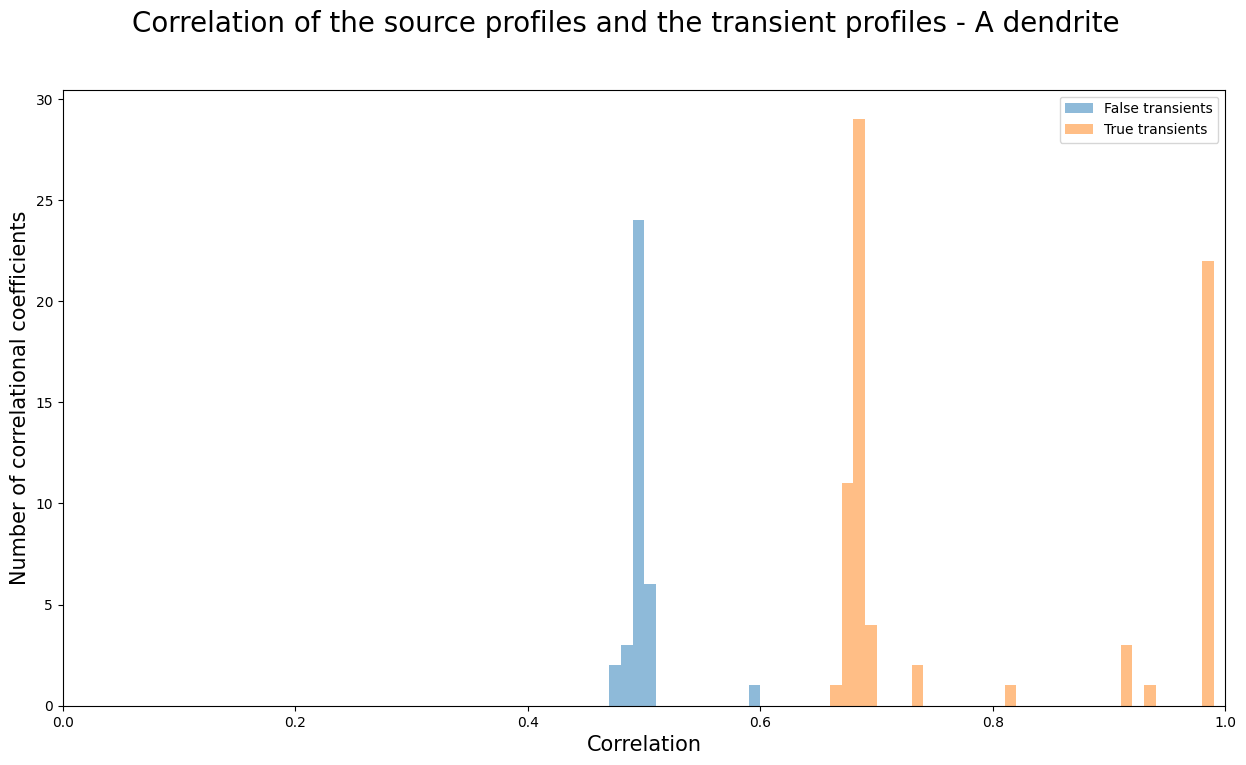

In [83]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

plt.hist(false_cor, bins = np.arange(0,1,0.01), alpha=0.5, label='False transients')
plt.hist(true_cor, bins = np.arange(0,1,0.01), alpha=0.5, label='True transients')
plt.legend(loc='upper right')
plt.suptitle('Correlation of the source profiles and the transient profiles - A dendrite', fontsize=20)
plt.xlabel('Correlation', fontsize = 15)
plt.ylabel('Number of correlational coefficients', fontsize = 15)
plt.savefig('transients/local_transients/dend_correlation_histogram.png')
plt.xlim(0,1)
plt.show()

Saving correlational coefficients of a certain soma or dendrite.

Here we call the plot function with the specific details of a soma or the dendrite.

In [ ]:
#exceptions for manually reclassifying the false transients
exception_list = true_indices

In [ ]:
# magazine(asoma_expanded, synthetic_a_soma_signal_smooth, synthetic_movie, asomabase,
#          lista_lower, lista_upper, synthetic_dF_a_soma, exception_list, pad_len, '{0}. A soma', 'transients/final_transients/a_soma_magazine.pdf') #{0}...